In [1]:
# WEB SCRAPING PART

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np 
import re
import json
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm 

from scipy import stats

In [3]:
url = 'https://www.sportbible.com/football/reactions-news-take-a-bow-the-top-100-best-male-footballers-in-the-world-ranked-20190522'
data = requests.get(url).content
soup = BeautifulSoup(data, "html.parser")

In [4]:
table = soup.find_all('p')
text = [t.text for t in table]
new_text = [t.split("Here's the full-list") for t in text]
list_names = new_text[6]

new_list = []
new_list2 = []
new_list3 = []
new_list4 = []
new_list5 = []

for i in list_names: # drop numbers from our list'
   pattern = '[^[0-9]+]*'
   new_list = re.findall(pattern, i)

for i in new_list: #drop '. '
   new_list2.append(i.split('. ')[1])

for i in new_list2: # drop '\n' from the end of list
   new_list3.append(i.split('\n')[0])

for i in new_list3: # split list by ' ' - at result we have list of lists
   new_list4.append(i.split(' '))

for i in new_list4: # result list : last name + first name
   if len(i) == 1:
       new_list5.append(i[0])
   elif len(i) == 2:
       new_list5.append(i[1]+ ' ' +i[0])
   elif len(i) == 3:
       new_list5.append(i[1]+ ' ' + i[2] + ' ' + i[0])

# correct text mistakes 
new_list5[new_list5.index('Van Dijk Virgl')] = 'Van Dijk Virgil'
new_list5[new_list5.index('Rakitic  Ivan')] = 'Rakitic Ivan'
new_list5[new_list5.index(' Fernandinho')] = 'Fernandinho'
new_list5[new_list5.index('Torreira  Lucas')] = 'Torreira Lucas'

In [5]:
# API PART

In [6]:
# loop for every name in list & making list for all API's
lst_api = []
for i in new_list5:
    data = 'https://apiv2.apifootball.com/?action=get_players&player_name={}'.format(i)+'&APIkey=4c2d6d595d5e02c1d00d3aeec4cd45eccc0b7c93605fb84a74dc5874450da995'
    lst_api.append(data) 

In [7]:
# get data out of all API's 
lst_data = []
for url in lst_api:
    response = requests.get(url)
    results = response.json() 
    lst_data.append(results)

In [8]:
# getting 1 level deeper (list of dics instead of list of lists of dics)
lst_data_2 = [y for x in lst_data for y in x]

In [9]:
# filter string 
final_list = []

for i in lst_data_2: 
    if type(i) is not str:
        final_list.append(i) 

In [10]:
# filter dictionary: if value in dict == name in name_list 
data_players = []

for dic in final_list:
    for k, v in dic.items():
        if v in new_list5:
            data_players.append(dic)

In [11]:
# make dataframe 
data = json_normalize(data_players) 

# split dataframe for double named players 
df_double_names = data[(data.player_name == 'Willian') | (data.player_name == 'Marcelo') 
                       | (data.player_name == 'Alisson') | (data.player_name == 'Jorginho') 
                       | (data.player_name == 'Fernandinho') | (data.player_name == 'Silva David') 
                       | (data.player_name == 'Hernandez Lucas')]

# only keep correct doubles 
df_double_names["combined"] = df_double_names.apply(lambda row: row.player_name+"*"+row.team_name, axis=1)
df_names_filter = df_double_names[df_double_names["combined"].isin(['Willian*Chelsea', 'Marcelo*Real Madrid', 
                                                                    'Alisson*Liverpool', 'Jorgihno*Chelsea', 
                                                                    'Fernandinho*Manchester City', 
                                                                    'Silva David*Manchester City', 
                                                                    'Hernandez Lucas*Bayern Munich'])==True]

df_names_filter.drop(['combined'], axis=1, inplace=True)

/Users/noortjetaal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/noortjetaal/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
# split data frame without double names 
df_no_double_names = data[(data.player_name != 'Willian') & (data.player_name != 'Marcelo') &
                          (data.player_name != 'Alisson') & (data.player_name != 'Jorginho') 
                          & (data.player_name != 'Fernandinho') & (data.player_name != 'Silva David') 
                          & (data.player_name != 'Hernandez Lucas')]

# create final data frame in which each correct name will be appear once 
final_data = df_no_double_names.append(df_names_filter)

# drop columns & change order 
final_data_2 = final_data[['player_name', 'player_age', 'player_country', 'team_name', 'player_type', 
                           'player_match_played', 'player_goals', 'player_red_cards', 'player_yellow_cards']]
final_data_2.head()

,player_name,player_age,player_country,team_name,player_type,player_match_played,player_goals,player_red_cards,player_yellow_cards
0,Modric Luka,34,Croatia,Real Madrid,Midfielders,3,0,1,0
1,Ronaldo Cristiano,34,Portugal,Juventus,Forwards,6,3,0,0
2,Messi Lionel,32,Argentina,Barcelona,Forwards,3,1,0,0
3,Mbappe Kylian,20,France,Paris SG,Forwards,5,2,0,0
4,Salah Mohamed,27,Egypt,Liverpool,Forwards,8,4,0,0


In [13]:
# check types & change some columns to int 
final_data_2.dtypes 

# make int of player_age, player_match_played, player_goals, player_red_cards, player_yellow_cards
final_data_2[['player_age', 'player_match_played', 'player_goals', 'player_red_cards',
              'player_yellow_cards']] = final_data_2[['player_age', 'player_match_played', 'player_goals', 
                                                      'player_red_cards', 'player_yellow_cards']].astype(int)
# check types again
final_data_2.dtypes 

# make colum avg goals/game after making them integers 
final_data_2['profit'] =  final_data_2['player_goals'] / final_data_2['player_match_played']
final_data_2.head()

/Users/noortjetaal/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/noortjetaal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,player_name,player_age,player_country,team_name,player_type,player_match_played,player_goals,player_red_cards,player_yellow_cards,profit
0,Modric Luka,34,Croatia,Real Madrid,Midfielders,3,0,1,0,0.000000
1,Ronaldo Cristiano,34,Portugal,Juventus,Forwards,6,3,0,0,0.500000
2,Messi Lionel,32,Argentina,Barcelona,Forwards,3,1,0,0,0.333333
3,Mbappe Kylian,20,France,Paris SG,Forwards,5,2,0,0,0.400000
4,Salah Mohamed,27,Egypt,Liverpool,Forwards,8,4,0,0,0.500000


In [14]:
# ANALYSE & VISUALISATION PART 

In [15]:
# descriptive statistics of dataframe 
final_data_2.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
player_age,85.0,28.694118,3.693700,20.0,26.0,28.000000,32.0,41.0
player_match_played,85.0,5.752941,2.473218,0.0,4.0,6.000000,8.0,9.0
player_goals,85.0,1.623529,2.198357,0.0,0.0,1.000000,2.0,12.0
player_red_cards,85.0,0.035294,0.185617,0.0,0.0,0.000000,0.0,1.0
player_yellow_cards,85.0,0.788235,1.070093,0.0,0.0,0.000000,1.0,5.0
profit,81.0,0.272443,0.318718,0.0,0.0,0.142857,0.5,1.5


In [16]:
# figure size 
plt.rcParams['figure.figsize'] = (8, 4) 

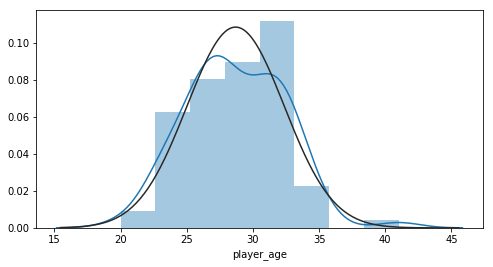

In [17]:
# distribution age 
sns.distplot(final_data_2['player_age'], fit=norm);

# our hypoteses was that age will have an effect on the amount goals or cards 
# for this reason it is interesting to look at the distribution of age 
# you can see that age is normal distributed 

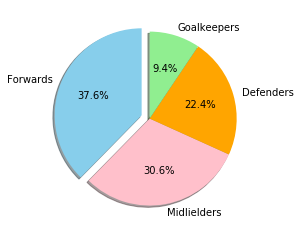

In [18]:
# piechart positions: for the best 85 footbalplayers, which position is most common? 
labels = ['Forwards', 'Midlielders', 'Defenders', 'Goalkeepers'] 
sizes = final_data_2['player_type'].value_counts()
explode = (0.1, 0, 0, 0)
colors = ['skyblue', 'pink', 'orange', 'lightgreen'] 

plt.pie(sizes, explode=explode, labels=labels, shadow=True, autopct='%1.1f%%', startangle=90, colors=colors);

In [19]:
# create df for only countries for piechart 
country = final_data_2['player_country'].value_counts()
country_data = pd.DataFrame(country)
country_data['country_name'] = country_data.index

other_data = country_data[country_data.player_country <= 5]
country_data_2 = country_data[country_data.player_country >= 6]

#create list labels piechart & list sizes piechart
list_labels = list(country_data_2['country_name'])
list_labels.append('other')

list_sizes = list(country_data_2['player_country'])
list_sizes.append(other_data.player_country.sum()) 

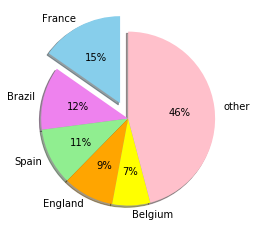

In [20]:
# piechart countries: for the best 85 footbalplayers, where (which countries) do the players come from? 
labels = list_labels
sizes = list_sizes
explode = (0.2, 0, 0, 0, 0, 0)
colors = ['skyblue', 'violet', 'lightgreen', 'orange', 'yellow', 'pink'] 

plt.pie(sizes, explode=explode, labels=labels, shadow=True, autopct='%1.0f%%', startangle=90, colors=colors);

In [21]:
# correlation matrix 
final_data_2.corr()

,player_age,player_match_played,player_goals,player_red_cards,player_yellow_cards,profit
player_age,1.000000,-0.077438,-0.005554,0.102752,-0.106939,0.016970
player_match_played,-0.077438,1.000000,0.372434,-0.110441,0.249887,0.086520
player_goals,-0.005554,0.372434,1.000000,-0.083748,0.061858,0.904773
player_red_cards,0.102752,-0.110441,-0.083748,1.000000,-0.021859,-0.086131
player_yellow_cards,-0.106939,0.249887,0.061858,-0.021859,1.000000,0.010098
profit,0.016970,0.086520,0.904773,-0.086131,0.010098,1.000000


In [22]:
# figure size 
plt.rcParams['figure.figsize'] = (26, 4) 

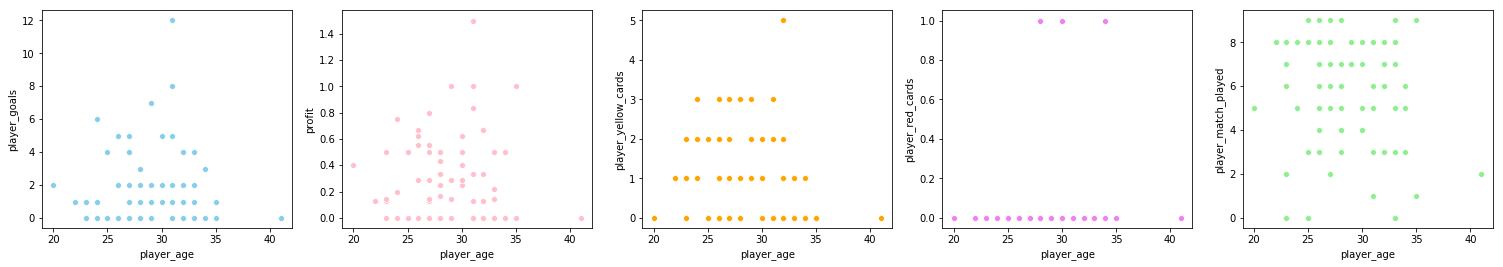

In [23]:
plt.subplot(1,5,1)
sns.scatterplot(x="player_age", y="player_goals", data=final_data_2, color = 'skyblue')
# conclusion: no lineair relationship, regplot not nessecary because you already see there is no relationship

plt.subplot(1,5,2)
sns.scatterplot(x="player_age", y="profit", data=final_data_2, color = 'pink');
# conclusion: no lineair relationship, regplot not nessecary because you already see there is no relationship

plt.subplot(1,5,3)
sns.scatterplot(x="player_age", y="player_yellow_cards", data=final_data_2, color = 'orange');
# conclusion: no lineair relationship, regplot not nessecary because you already see there is no relationship

plt.subplot(1,5,4)
sns.scatterplot(x="player_age", y="player_red_cards", data=final_data_2, color = 'violet');
# conclusion: no lineair relationship, regplot not nessecary because you already see there is no relationship 

plt.subplot(1,5,5)
sns.scatterplot(x="player_age", y="player_match_played", data=final_data_2, color = 'lightgreen');
# conclusion: no lineair relationship, regplot not nessecary because you already see there is no relationship

# main conclusion age: there is no lineair relationship bewteen age and every other variable
# against what we were expecting: age is not a pedictor 

In [24]:
# figure size
plt.rcParams['figure.figsize'] = (8, 4) 

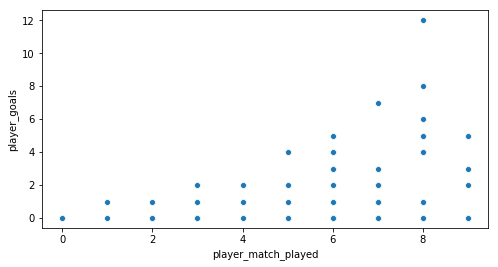

In [25]:
# scatterplot match played & goals
sns.scatterplot(x="player_match_played", y="player_goals", data=final_data_2); 

# conclusion: there might be a lineair relationship

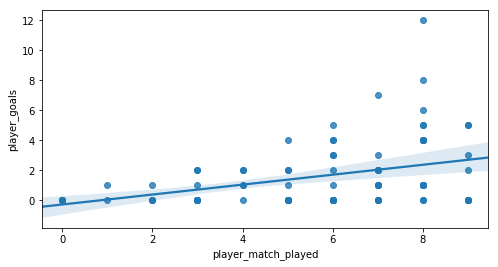

In [26]:
# reg plot match played & goals
sns.regplot(x="player_match_played", y="player_goals", data=final_data_2);

In [27]:
# regression formula match played & goals
x = final_data_2['player_match_played']
y = final_data_2['player_goals']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y) 
all_stats = stats.linregress(x, y)

print('The slope is:', slope)
print('The intercept is:', intercept) 
print('Regression: goals =',slope, intercept,'* matches_played\n')
print('The std. error is:', std_err) 
print('It is', std_err < 0.1, 'that the std. error is small and that the x varaiable is a good predictor')

The slope is: 0.3310436415258509
The intercept is: -0.2809451847781306
Regression: goals = 0.3310436415258509 -0.2809451847781306 * matches_played

The std. error is: 0.09054661067517944
It is True that the std. error is small and that the x varaiable is a good predictor


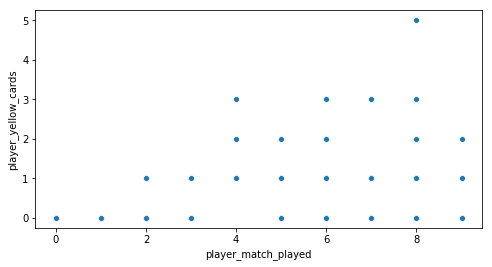

In [28]:
# scatterplot match played & yellow_cards
sns.scatterplot(x="player_match_played", y="player_yellow_cards", data=final_data_2);

# conclusion: there might be a lineair relationship 

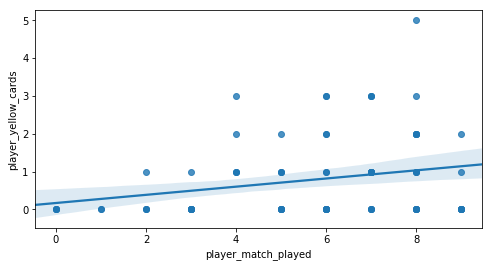

In [29]:
# reg plot match played & yellow_cards
sns.regplot(x="player_match_played", y="player_yellow_cards", data=final_data_2);

In [30]:
# regression formula yellow_cards & match played 
x = final_data_2['player_match_played']
y = final_data_2['player_yellow_cards']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y) 
all_stats = stats.linregress(x, y)

print('The slope is:', slope)
print('The intercept is:', intercept) 
print('Regression: goals =',slope,'+',intercept,'* yellow_cards\n')
print('The std. error is:', std_err) 
print('It is', std_err < 0.1, 'that the std. error is small and that the x varaiable is a good predictor')

The slope is: 0.10811924714933377
The intercept is: 0.16623162522324453
Regression: goals = 0.10811924714933377 + 0.16623162522324453 * yellow_cards

The std. error is: 0.04598525570087956
It is True that the std. error is small and that the x varaiable is a good predictor
